In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
#1 Load the uploaded CSV file to inspect its content
file_path = 'water_potability.csv'
water_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [21]:
# Step 2: Check and Handle Missing Values
print("\nMissing Values Before Imputation:\n", water_data.isnull().sum())
columns_to_impute = ['ph', 'Sulfate', 'Trihalomethanes']
for column in columns_to_impute:
    water_data[column].fillna(water_data[column].mean(), inplace=True)
print("\nMissing Values After Imputation:\n", water_data.isnull().sum())


Missing Values Before Imputation:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Missing Values After Imputation:
 ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


<ipython-input-21-0fcfa2e59722>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  water_data[column].fillna(water_data[column].mean(), inplace=True)


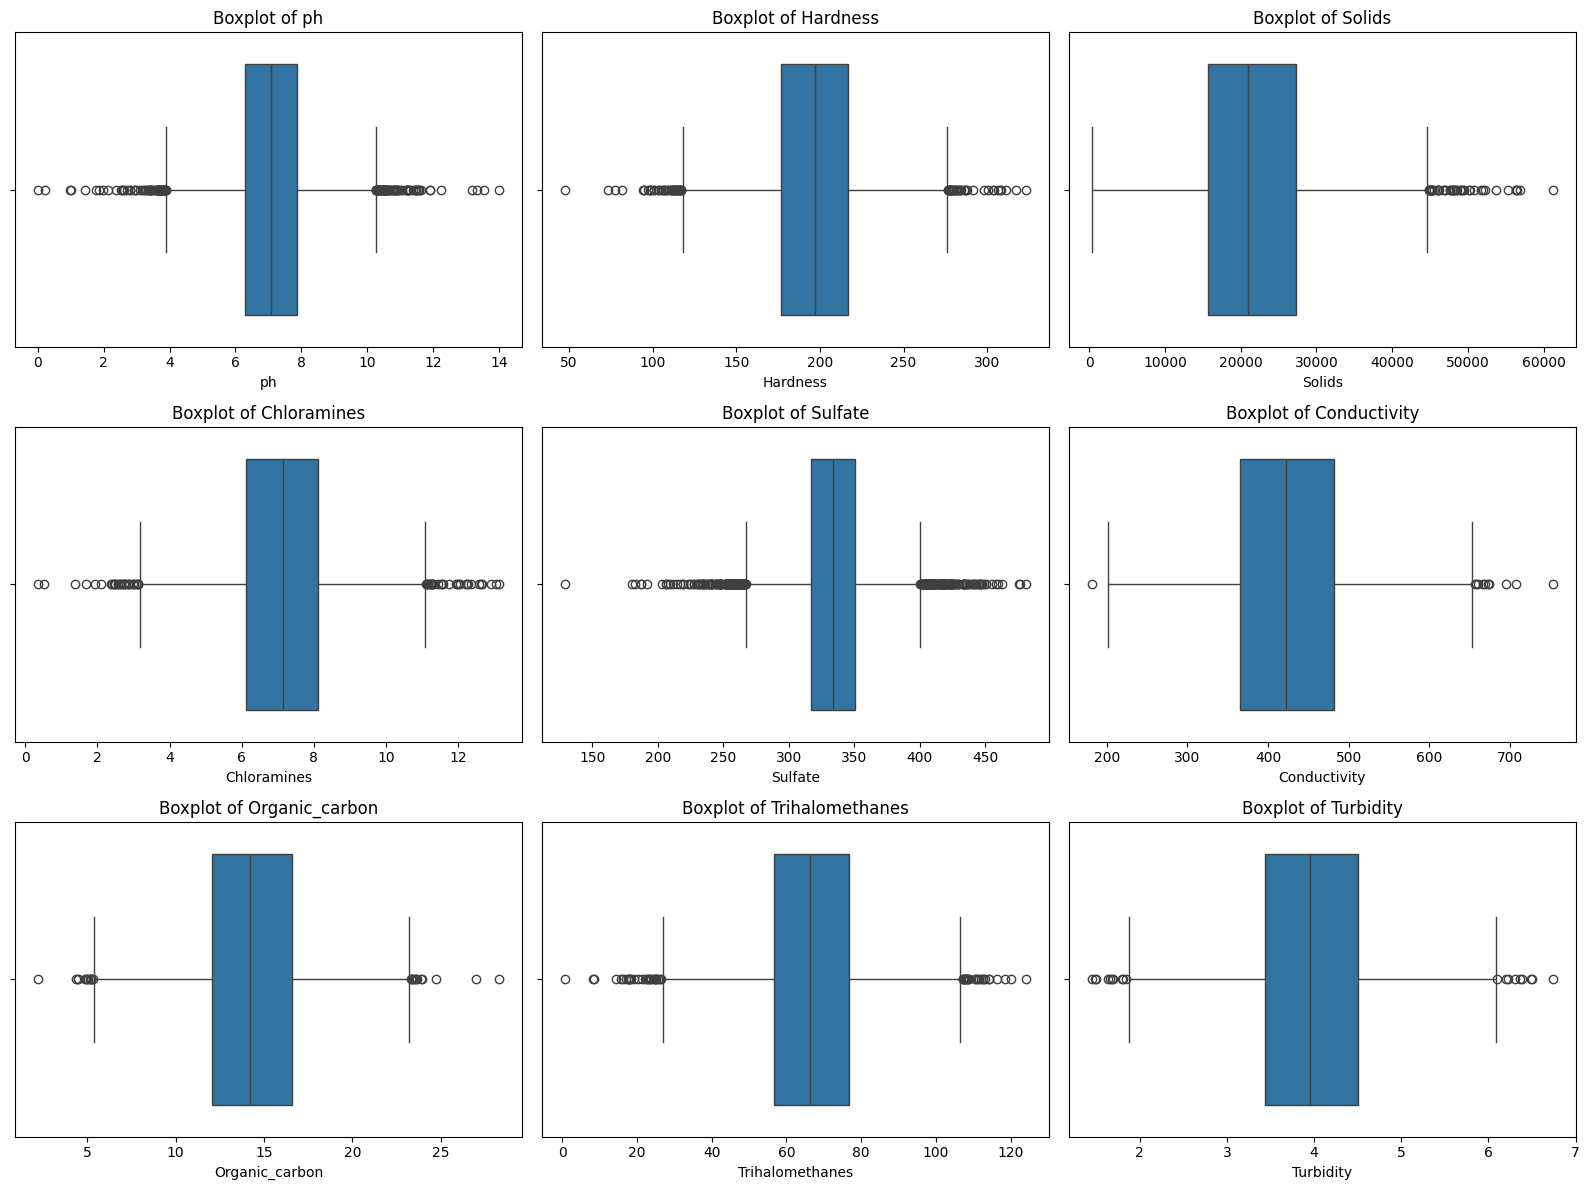

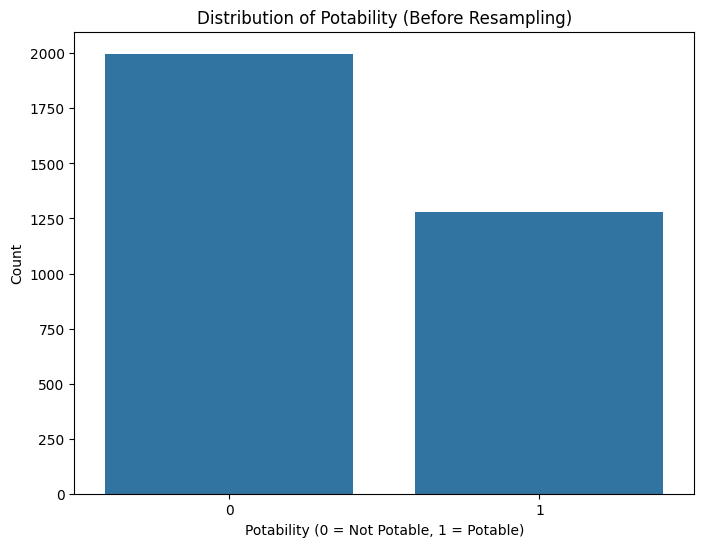

In [22]:
# Step 3: Visualize Outliers and Data Distribution
plt.figure(figsize=(16, 12))
for i, column in enumerate(water_data.columns[:-1], 1):  # Exclude 'Potability'
    plt.subplot(3, 3, i)
    sns.boxplot(data=water_data, x=column)
    plt.title(f"Boxplot of {column}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(data=water_data, x="Potability")
plt.title("Distribution of Potability (Before Resampling)")
plt.xlabel("Potability (0 = Not Potable, 1 = Potable)")
plt.ylabel("Count")
plt.show()


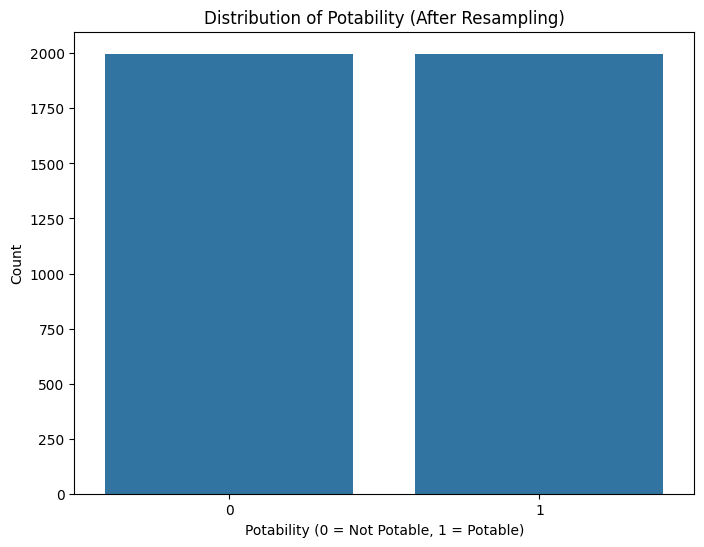

In [23]:
# Step 4: Resample Data to Balance Classes
data_majority = water_data[water_data['Potability'] == 0]
data_minority = water_data[water_data['Potability'] == 1]
data_minority_oversampled = resample(data_minority,
                                     replace=True,  # Sample with replacement
                                     n_samples=len(data_majority),  # Match majority class
                                     random_state=42)
water_data_resampled = pd.concat([data_majority, data_minority_oversampled])

plt.figure(figsize=(8, 6))
sns.countplot(data=water_data_resampled, x="Potability")
plt.title("Distribution of Potability (After Resampling)")
plt.xlabel("Potability (0 = Not Potable, 1 = Potable)")
plt.ylabel("Count")
plt.show()

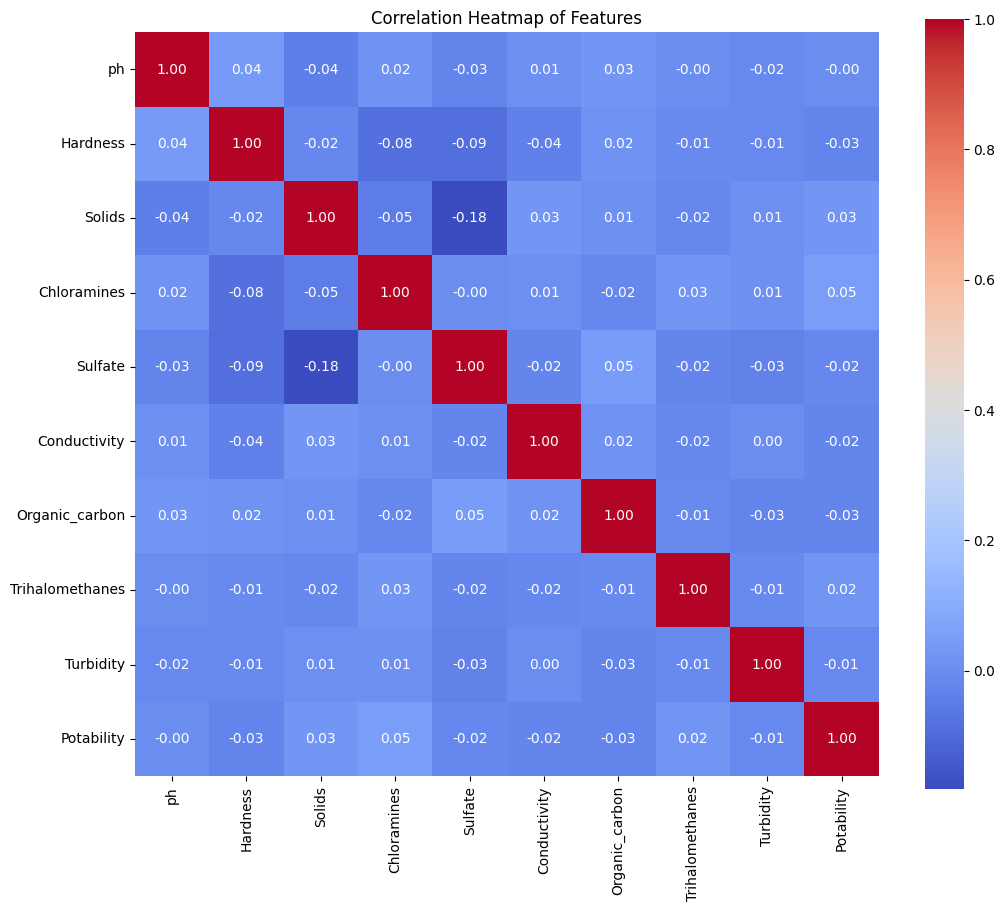

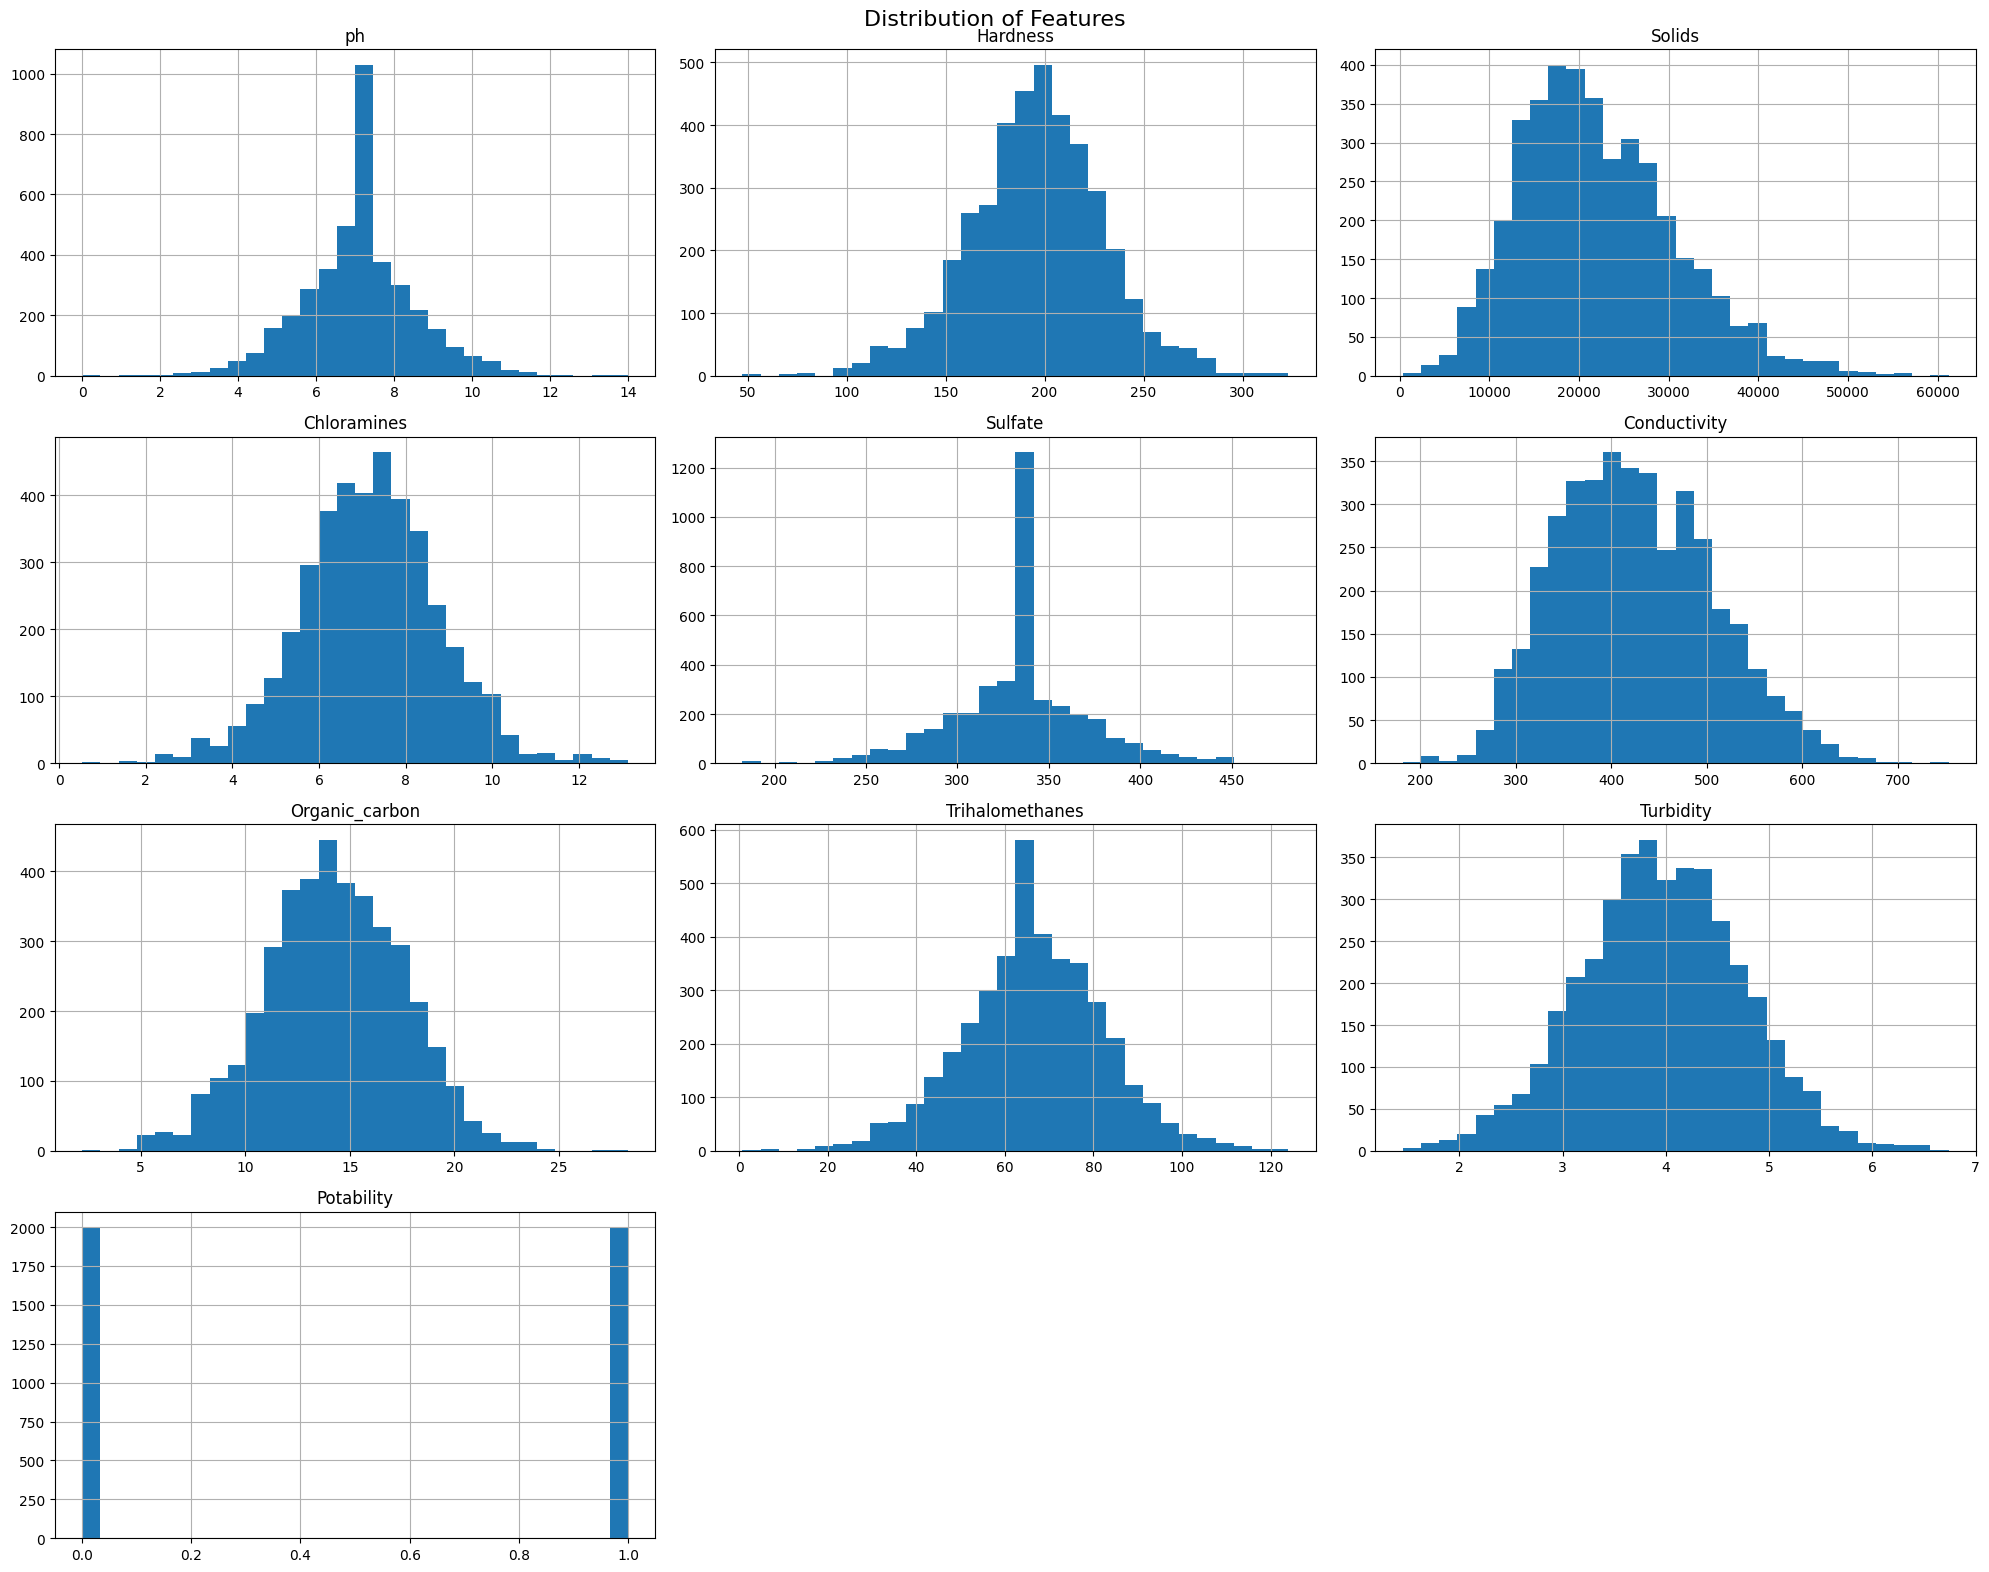

In [24]:
# Step 5: Visualize Correlation Heatmap and Feature Distributions
plt.figure(figsize=(12, 10))
correlation_matrix = water_data_resampled.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Features")
plt.show()

water_data_resampled.hist(bins=30, figsize=(20, 16), layout=(4, 3))
plt.suptitle("Distribution of Features", fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
# Step 6: Prepare Data for Modeling
X = water_data_resampled.drop("Potability", axis=1)
y = water_data_resampled["Potability"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:02:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


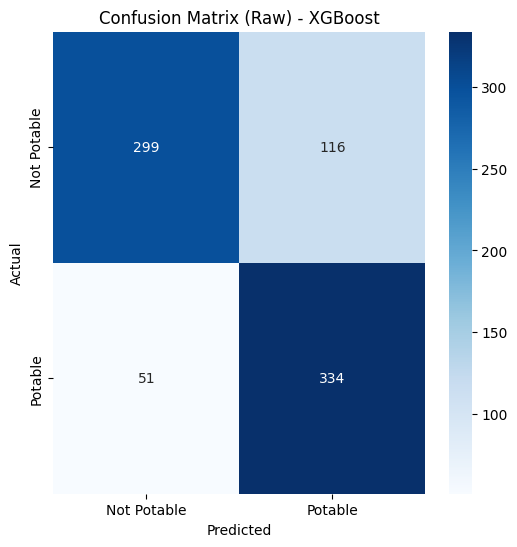

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:02:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


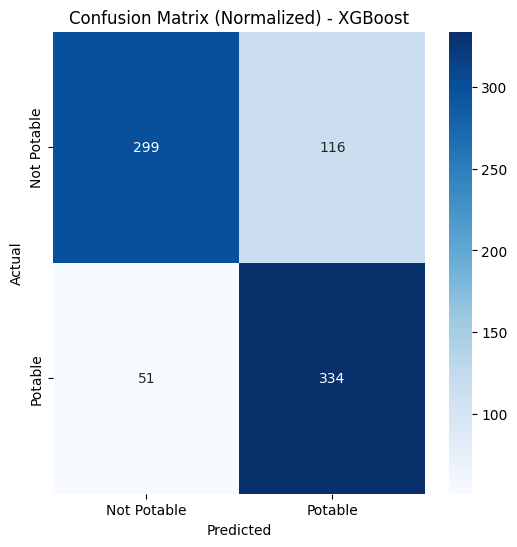

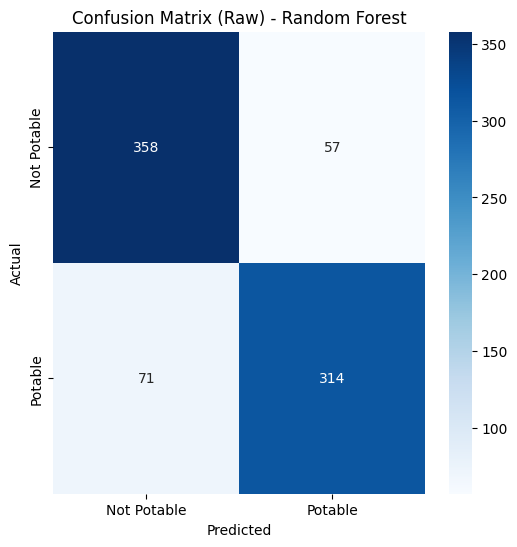

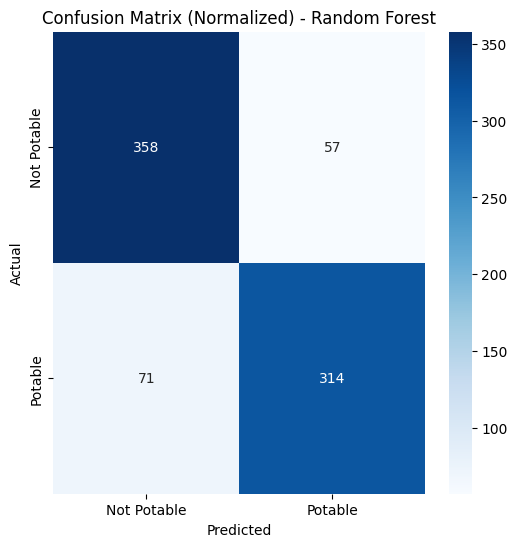

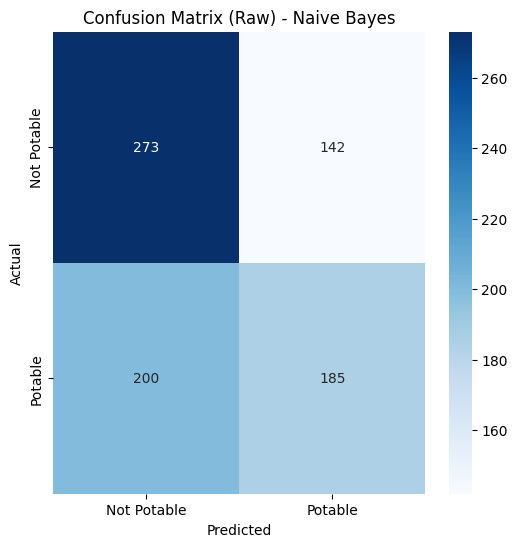

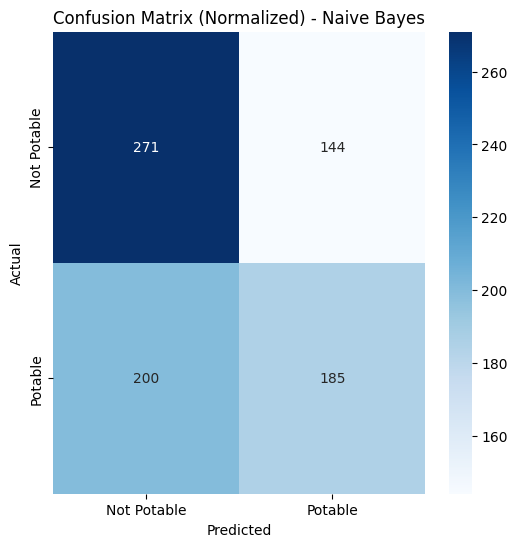

In [26]:
# Step 7: Build and Evaluate Models
models = {
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

results = {}

for model_name, model in models.items():
    # Without normalization
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Plot confusion matrix for raw data
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Potable", "Potable"], yticklabels=["Not Potable", "Potable"])
    plt.title(f"Confusion Matrix (Raw) - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # With normalization (for models that benefit from it)
    model.fit(X_train_scaled, y_train)
    y_pred_scaled = model.predict(X_test_scaled)
    acc_scaled = accuracy_score(y_test, y_pred_scaled)
    cm_scaled = confusion_matrix(y_test, y_pred_scaled)
    report_scaled = classification_report(y_test, y_pred_scaled, output_dict=True)

    # Plot confusion matrix for normalized data
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_scaled, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Potable", "Potable"], yticklabels=["Not Potable", "Potable"])
    plt.title(f"Confusion Matrix (Normalized) - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save results
    results[model_name] = {
        "Accuracy (Raw)": acc,
        "Confusion Matrix (Raw)": cm,
        "Classification Report (Raw)": report,
        "Accuracy (Normalized)": acc_scaled,
        "Confusion Matrix (Normalized)": cm_scaled,
        "Classification Report (Normalized)": report_scaled
    }



In [27]:
# Step 8: Display Results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy (Raw): {metrics['Accuracy (Raw)']:.2f}")
    print(f"Accuracy (Normalized): {metrics['Accuracy (Normalized)']:.2f}")


Model: XGBoost
Accuracy (Raw): 0.79
Accuracy (Normalized): 0.79

Model: Random Forest
Accuracy (Raw): 0.84
Accuracy (Normalized): 0.84

Model: Naive Bayes
Accuracy (Raw): 0.57
Accuracy (Normalized): 0.57


In [28]:
import joblib
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [29]:
# Simpan setiap model setelah dilatih
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    joblib.dump(model, f"{model_name.lower().replace(' ', '_')}.pkl")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:02:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
